In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix
from matplotlib.gridspec import GridSpec

from scipy.special import logit, expit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

cm = 1/2.54

In [2]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests


def run_kw(exon_psi, labels):
    kw_input = []
    for l in labels:
        kw_input.append(list(exon_psi[l]))
        
    if len(labels) == 2:
        return kruskal(kw_input[0], kw_input[1], nan_policy='omit')
    if len(labels) == 3:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], nan_policy='omit')
    if len(labels) == 4:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], nan_policy='omit')
    if len(labels) == 5:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], nan_policy='omit')
    if len(labels) == 6:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], nan_policy='omit')
    if len(labels) == 7:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], kw_input[6], nan_policy='omit')
    if len(labels) == 8:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], kw_input[6], kw_input[7], nan_policy='omit')
    
def run_kw_dset(psi_table, labels, exon_list):
    kw_output = pd.DataFrame()
    kw_score = []
    pvals = []
    for exon in tqdm(exon_list, position=0, leave=True):
        score, p = run_kw(psi_table.loc[exon], labels)
        kw_score.append(score)
        pvals.append(p)
    kw_output['KW_score'] = kw_score
    kw_output['pvals'] = pvals
    kw_output['qvals'] = multipletests(pvals, method='fdr_bh')[1]
    kw_output.index = exon_list
    return kw_output



In [20]:
# psix_three_lineage_1 = psix.Psix()
# psix_three_lineage_1.process_rnaseq(
#         'three_lineages/processed_tables/SE_counts_0.1.tab.gz',
#         'three_lineages/processed_tables/constitutive_introns_0.1.tab.gz',
#         'three_lineages/processed_tables/tpm_0.1.tab.gz',
#         minJR = 1,
#         minCell=1,
#         min_observed = 0.25)

# psix_three_lineage_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25, 
#                                 n_random_exons=2000, n_neighbors=100)

# psix_three_lineage_05 = psix.Psix()
# psix_three_lineage_05.process_rnaseq(
#         'three_lineages/processed_tables/SE_counts_0.05.tab.gz',
#         'three_lineages/processed_tables/constitutive_introns_0.05.tab.gz',
#         'three_lineages/processed_tables/tpm_0.05.tab.gz',
#         minJR = 1,
#         minCell=1,
#         min_observed = 0.25)

# psix_three_lineage_05.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25, 
#                                 n_random_exons=2000, n_neighbors=100)

# psix_three_lineage_01 = psix.Psix()
# psix_three_lineage_01.process_rnaseq(
#         'three_lineages/processed_tables/SE_counts_0.01.tab.gz',
#         'three_lineages/processed_tables/constitutive_introns_0.01.tab.gz',
#         'three_lineages/processed_tables/tpm_0.01.tab.gz',
#         minJR = 1,
#         minCell=1,
#         min_observed = 0.25)

# psix_three_lineage_01.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25, 
#                                 n_random_exons=2000, n_neighbors=100)


# meta = pd.read_csv('three_lineages/sim_output/meta.tab.gz', sep='\t')
# meta.index=['cell_'+str(i+1) for i in range(1000)]

# #pop_1 = meta.loc[meta['pop'] == '4_1'].index
# #pop_2 = meta.loc[meta['pop'] == '4_5'].index
# #pop_3 = meta.loc[meta['pop'] == '5_2'].index
# #pop_4 = meta.loc[meta['pop'] == '5_3'].index
# #labels = [pop_1, pop_2, pop_3, pop_4]

pop_1 = meta.loc[meta['pop'] == '4_1'].index
pop_2 = meta.loc[meta['pop'] == '4_5'].index
pop_2 = pop_2 | meta.loc[meta['pop'] == '5_2'].index
pop_3 = meta.loc[meta['pop'] == '5_3'].index
labels = [pop_1, pop_2, pop_3]

three_kw_1 = run_kw_dset(psix_three_lineage_1.adata.uns['psi'][psix_three_lineage_1.psix_results.index].T, 
                         labels, psix_three_lineage_1.psix_results.index)

three_kw_05 = run_kw_dset(psix_three_lineage_05.adata.uns['psi'][psix_three_lineage_05.psix_results.index].T, 
                         labels, psix_three_lineage_05.psix_results.index)

three_kw_01 = run_kw_dset(psix_three_lineage_01.adata.uns['psi'][psix_three_lineage_01.psix_results.index].T, 
                         labels, psix_three_lineage_01.psix_results.index)

l1 = []
with open('three_lineages/sim_output/l1_diff.txt', 'r') as l1_file:
    for i in l1_file:
        l1.append(int(i.rstrip()))
        
l2 = []
with open('three_lineages/sim_output/l2_diff.txt', 'r') as l2_file:
    for i in l2_file:
        l2.append(int(i.rstrip()))
        
l3 = []
with open('three_lineages/sim_output/l3_diff.txt', 'r') as l3_file:
    for i in l3_file:
        l3.append(int(i.rstrip()))
        
l1 = np.array(l1)
l2 = np.array(l2)
l3 = np.array(l3)

ds = ((l1 + l2 + l3)>0).astype(int)

gearyc_3l_1 = pd.read_csv('three_lineages/gearyc_0.1.tab.gz', sep='\t', index_col=0)
gearyc_3l_05 = pd.read_csv('three_lineages/gearyc_0.05.tab.gz', sep='\t', index_col=0)
gearyc_3l_01 = pd.read_csv('three_lineages/gearyc_0.01.tab.gz', sep='\t', index_col=0)

100%|██████████| 1879/1879 [00:13<00:00, 139.91it/s]


In [49]:
from scipy.special import logit, expit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

platonic_psi = pd.read_csv('three_lineages/sim_output/psi_platonic.tab.gz', sep='\t', 
                               names = ['cell_'+str(i+1) for i in range(1000)])
platonic_psi.index = ['gene' + str(i+1) for i in range(5000)]

platonic_psi = expit(platonic_psi)


psix_results_1 = psix_three_lineage_1.psix_results

names = pd.Index(['gene' + str(i) for i in range(1, 5001)]) & psix_results_1.index

pos = []
neg = []
for i in range(5000):
    if ('gene'+str(i+1)) in psix_results_1.index:

        if (platonic_psi.loc['gene'+str(i+1)].max() - platonic_psi.loc['gene'+str(i+1)].min()) >= 0.2:
            pos.append('gene'+str(i+1))
        else:
#         elif ds[i] == 0:
            neg.append('gene'+str(i+1))



psix_auc_1 = []
kw_auc_1 = []
gearyc_3l_auc_1 = []
    
for i in tqdm(range(200)):
    
    pos_sample = np.random.choice(pos, int(len(pos)*0.2), replace=False)
    neg_sample = np.random.choice(neg, int(len(neg)*0.2), replace=False)
    
    labels = [1]*len(pos_sample) + [0]*len(neg_sample)
    order = list(pos_sample) + list(neg_sample)

    
    y_ = list(((platonic_psi.max(axis=1) - platonic_psi.min(axis=1)) >= 0.2).astype(int).loc[order])


    pre, rec, thres = precision_recall_curve(y_, psix_results_1.loc[order].psix_score)
    pre_kw, rec_kw, thres_kw = precision_recall_curve(y_, three_kw_1.loc[order].KW_score)
    pre_c, rec_c, thres_c = precision_recall_curve(y_, gearyc_3l_1.loc[order].C_score)

    psix_auc_1.append(auc(rec, pre))
    kw_auc_1.append(auc(rec_kw, pre_kw))
    gearyc_3l_auc_1.append(auc(rec_c, pre_c))
    

    
# boxplots = [ psix_auc_1, gearyc_3l_auc_1, kw_auc_1]



# bp = plt.boxplot(boxplots)


# plt.xticks(np.arange(1, 4), 
#            ['Psix', "Geary's C", 'KW'], fontsize=14, rotation=90)

# plt.ylabel('AUC pre-rec curve', fontsize=14)
# # plt.xlabel('Method', fontsize=14)
# plt.title('Method comparison, Tiklova dataset', fontsize=14)

100%|██████████| 200/200 [00:08<00:00, 24.93it/s]


In [50]:
from scipy.special import logit, expit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

psix_results_05 = psix_three_lineage_05.psix_results

names = pd.Index(['gene' + str(i) for i in range(1, 5001)]) & psix_results_05.index

pos = []
neg = []
for i in range(5000):
    if ('gene'+str(i+1)) in psix_results_05.index:

        if (platonic_psi.loc['gene'+str(i+1)].max() - platonic_psi.loc['gene'+str(i+1)].min()) >= 0.2:
            pos.append('gene'+str(i+1))
        else:
#         elif ds[i] == 0:
            neg.append('gene'+str(i+1))


# platonic_psi = pd.read_csv('three_lineages/sim_output/psi_platonic.tab.gz', sep='\t', 
#                                names = ['cell_'+str(i+1) for i in range(1000)])
# platonic_psi.index = ['gene' + str(i+1) for i in range(5000)]

# platonic_psi = expit(platonic_psi)

psix_auc_05 = []
kw_auc_05 = []
gearyc_3l_auc_05 = []
    
for i in tqdm(range(200)):
    
    pos_sample = np.random.choice(pos, int(len(pos)*0.2), replace=False)
    neg_sample = np.random.choice(neg, int(len(neg)*0.2), replace=False)
    
    labels = [1]*len(pos_sample) + [0]*len(neg_sample)
    order = list(pos_sample) + list(neg_sample)

    
    y_ = list(((platonic_psi.max(axis=1) - platonic_psi.min(axis=1)) >= 0.2).astype(int).loc[order])


    pre, rec, thres = precision_recall_curve(y_, psix_results_05.loc[order].psix_score)
    pre_kw, rec_kw, thres_kw = precision_recall_curve(y_, three_kw_05.loc[order].KW_score)
    pre_c, rec_c, thres_c = precision_recall_curve(y_, gearyc_3l_05.loc[order].C_score)

    psix_auc_05.append(auc(rec, pre))
    kw_auc_05.append(auc(rec_kw, pre_kw))
    gearyc_3l_auc_05.append(auc(rec_c, pre_c))
    

    
# boxplots = [ psix_auc_05, gearyc_3l_auc_05, kw_auc_05]



# bp = plt.boxplot(boxplots)


# plt.xticks(np.arange(1, 4), 
#            ['Psix', "Geary's C", 'KW'], fontsize=14, rotation=90)

# plt.ylabel('AUC pre-rec curve', fontsize=14)
# # plt.xlabel('Method', fontsize=14)
# plt.title('Method comparison, Tiklova dataset', fontsize=14)

100%|██████████| 200/200 [00:07<00:00, 25.46it/s]


In [51]:
from scipy.special import logit, expit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

psix_results_01 = psix_three_lineage_01.psix_results

names = pd.Index(['gene' + str(i) for i in range(1, 5001)]) & psix_results_01.index

pos = []
neg = []
for i in range(5000):
    if ('gene'+str(i+1)) in psix_results_01.index:

        if (platonic_psi.loc['gene'+str(i+1)].max() - platonic_psi.loc['gene'+str(i+1)].min()) >= 0.2:
            pos.append('gene'+str(i+1))
        else:
        #elif ds[i] == 0:
            neg.append('gene'+str(i+1))


# platonic_psi = pd.read_csv('three_lineages/sim_output/psi_platonic.tab.gz', sep='\t', 
#                                names = ['cell_'+str(i+1) for i in range(1000)])
# platonic_psi.index = ['gene' + str(i+1) for i in range(5000)]

# platonic_psi = expit(platonic_psi)

psix_auc_01 = []
kw_auc_01 = []
gearyc_3l_auc_01 = []
    
for i in tqdm(range(200)):
    
    pos_sample = np.random.choice(pos, int(len(pos)*0.2), replace=False)
    neg_sample = np.random.choice(neg, int(len(neg)*0.2), replace=False)
    
    labels = [1]*len(pos_sample) + [0]*len(neg_sample)
    order = list(pos_sample) + list(neg_sample)

    
    y_ = list(((platonic_psi.max(axis=1) - platonic_psi.min(axis=1)) >= 0.2).astype(int).loc[order])


    pre, rec, thres = precision_recall_curve(y_, psix_results_01.loc[order].psix_score)
    pre_kw, rec_kw, thres_kw = precision_recall_curve(y_, three_kw_01.loc[order].KW_score)
    pre_c, rec_c, thres_c = precision_recall_curve(y_, gearyc_3l_01.loc[order].C_score)

    psix_auc_01.append(auc(rec, pre))
    kw_auc_01.append(auc(rec_kw, pre_kw))
    gearyc_3l_auc_01.append(auc(rec_c, pre_c))
    

    
# boxplots = [ psix_auc_01, gearyc_3l_auc_01, kw_auc_01]



# bp = plt.boxplot(boxplots)


# plt.xticks(np.arange(1, 4), 
#            ['Psix', "Geary's C", 'KW'], fontsize=14, rotation=90)

# plt.ylabel('AUC pre-rec curve', fontsize=14)
# # plt.xlabel('Method', fontsize=14)
# plt.title('Method comparison, Tiklova dataset', fontsize=14)


100%|██████████| 200/200 [00:06<00:00, 31.25it/s]


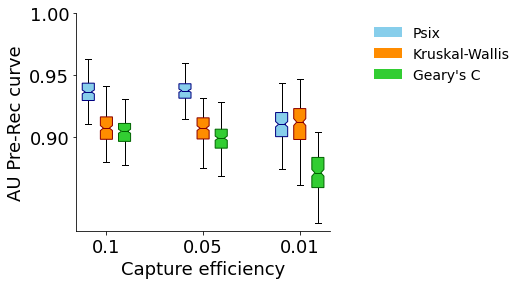

In [52]:
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1,7)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4])
ax_2 = fig.add_subplot(gs[0,4:7])# option 1, specify props dictionaries

ax.boxplot([psix_auc_1, psix_auc_05, psix_auc_01], positions=[1,5,9], notch=True, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='navy'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='navy'), showfliers=False
            )

ax.boxplot([kw_auc_1, kw_auc_05, kw_auc_01], positions=[1.75,5.75,9.75], notch=True, patch_artist=True,
            boxprops=dict(facecolor='darkorange', color='darkred'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkred'), showfliers=False
            )

ax.boxplot([gearyc_3l_auc_1, gearyc_3l_auc_05, gearyc_3l_auc_01], positions=[2.5,6.5,10.5], notch=True, patch_artist=True,
            boxprops=dict(facecolor='limegreen', color='darkgreen'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkgreen'), showfliers=False
            )

ax.set_xticks([1.75, 5.75, 9.75])
ax.set_xticklabels(['0.1', '0.05', '0.01'], size=18)
ax.set_xlabel('Capture efficiency', size=18)

ax.set_yticks([0.9, 0.95, 1])
ax.set_yticklabels(['0.90', '0.95', '1.00'], size=18)
ax.set_ylabel('AU Pre-Rec curve', size=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax_2.set_xlim([0, 0])

ax_2.hist([-1, -1], color='skyblue', label='Psix')
ax_2.hist([-1, -1], color='darkorange', label='Kruskal-Wallis')
ax_2.hist([-1, -1], color='limegreen', label="Geary's C")

ax_2.spines["bottom"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["right"].set_visible(False)
ax_2.spines["left"].set_visible(False)

ax_2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    right=False,
    left=False, # ticks along the top edge are off
    labelleft=False,
    labelbottom=False)

ax_2.legend(frameon=False, fontsize=14)

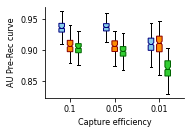

In [55]:
fig = plt.figure(figsize=(6/2.4, 4/2.4))
# gs = GridSpec(1,7)
# gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(111)
# ax_2 = fig.add_subplot(gs[0,4:7])# option 1, specify props dictionaries

ax.boxplot([psix_auc_1, psix_auc_05, psix_auc_01], positions=[1,5,9], notch=True, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='navy'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='navy'), showfliers=False
            )

ax.boxplot([kw_auc_1, kw_auc_05, kw_auc_01], positions=[1.75,5.75,9.75], notch=True, patch_artist=True,
            boxprops=dict(facecolor='darkorange', color='darkred'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkred'), showfliers=False
            )

ax.boxplot([gearyc_3l_auc_1, gearyc_3l_auc_05, gearyc_3l_auc_01], positions=[2.5,6.5,10.5], notch=True, patch_artist=True,
            boxprops=dict(facecolor='limegreen', color='darkgreen'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkgreen'), showfliers=False
            )

ax.set_xticks([1.75, 5.75, 9.75])
ax.set_xticklabels(['0.1', '0.05', '0.01'], size=8)
ax.set_xlabel('Capture efficiency', size=8)

ax.set_yticks([0.85, 0.9, 0.95])
ax.set_yticklabels(['0.85', '0.90', '0.95'], size=8)
ax.set_ylabel('AU Pre-Rec curve', size=8)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim([-0.5, 12])

plt.savefig('three_lineages/sub_plots/three_lineages_auc.png', bbox_inches='tight', res=20000, dpi =2000)

In [ ]:
import os
psix_three_lineages_1 = psix.Psix()
psix_three_lineages_1.process_rnaseq(
        'three_lineages/processed_tables/SE_counts_0.1.tab.gz',
        'three_lineages/processed_tables/constitutive_introns_0.1.tab.gz',
        'three_lineages/processed_tables/tpm_0.1.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

# os.mkdir('k_sensitivity_3lineages/')


psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=5)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_5.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=10)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_10.tab.gz', sep='\t', index=True, header=True)


psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=20)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_20.tab.gz', sep='\t', index=True, header=True)


psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=30)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_30.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=50)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_50.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=100)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_100.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=150)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_150.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=200)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_200.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=250)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_250.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=300)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_300.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=400)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_400.tab.gz', sep='\t', index=True, header=True)

psix_three_lineages_1.compute_psix_scores(latent='three_lineages/processed_tables/pc2_rd.tab.gz', n_jobs=25,
                                n_random_exons=2000, n_neighbors=500)
psix_three_lineages_1.psix_results.to_csv('k_sensitivity_3lineages/k_500.tab.gz', sep='\t', index=True, header=True)


Obtaining psi tables...
Reading TPM and transforming to mRNA counts...
mariados
luigi
prueba 2


100%|██████████| 1000/1000 [00:00<00:00, 42119.94it/s]

Successfully processed RNA-seq data
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 3354 exons



100%|██████████| 3354/3354 [00:54<00:00, 61.08it/s]  


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1000/1000 [00:00<00:00, 36925.27it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 3354 exons



100%|██████████| 3354/3354 [00:35<00:00, 95.06it/s]  


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1000/1000 [00:00<00:00, 20955.17it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 3354 exons



100%|██████████| 3354/3354 [00:34<00:00, 98.03it/s]  


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1000/1000 [00:00<00:00, 16549.49it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 3354 exons



100%|██████████| 3354/3354 [00:33<00:00, 100.95it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


In [57]:
psix_5 = pd.read_csv('k_sensitivity_3lineages/k_5.tab.gz', sep='\t', index_col=0)
psix_10 = pd.read_csv('k_sensitivity_3lineages/k_10.tab.gz', sep='\t', index_col=0)
psix_20 = pd.read_csv('k_sensitivity_3lineages/k_20.tab.gz', sep='\t', index_col=0)
psix_30 = pd.read_csv('k_sensitivity_3lineages/k_30.tab.gz', sep='\t', index_col=0)
psix_50 = pd.read_csv('k_sensitivity_3lineages/k_50.tab.gz', sep='\t', index_col=0)
psix_100 = pd.read_csv('k_sensitivity_3lineages/k_100.tab.gz', sep='\t', index_col=0)
psix_150 = pd.read_csv('k_sensitivity_3lineages/k_150.tab.gz', sep='\t', index_col=0)
psix_200 = pd.read_csv('k_sensitivity_3lineages/k_200.tab.gz', sep='\t', index_col=0)
psix_300 = pd.read_csv('k_sensitivity_3lineages/k_300.tab.gz', sep='\t', index_col=0)
psix_400 = pd.read_csv('k_sensitivity_3lineages/k_400.tab.gz', sep='\t', index_col=0)
psix_500 = pd.read_csv('k_sensitivity_3lineages/k_500.tab.gz', sep='\t', index_col=0)

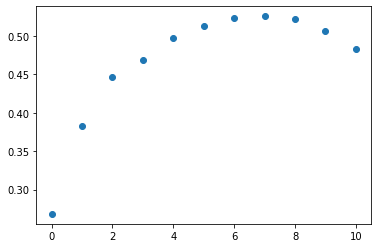

In [80]:
from scipy.special import logit, expit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score

names = pd.Index(['gene' + str(i) for i in range(1, 5001)]) & psix_5.index

pos = []
neg = []
order = []
y = []
for i in range(5000):
    if ('gene'+str(i+1)) in psix_5.index:

        if (platonic_psi.loc['gene'+str(i+1)].max() - platonic_psi.loc['gene'+str(i+1)].min()) >= 0.000001:
            y.append(1)
            pos.append('gene'+str(i+1))
            order.append('gene'+str(i+1))
        else:
#         elif ds[i] == 0:
            neg.append('gene'+str(i+1))
            y.append(0)
            order.append('gene'+str(i+1))
    
    

recall_list = [f1_score(y, x.loc[order].qvals <= 0.05) for x in [psix_5, psix_10, psix_20, psix_30, psix_50, psix_100, 
                                                                psix_150, psix_200, psix_300, psix_400, psix_500]]
plt.scatter(range(len(recall_list)), recall_list)

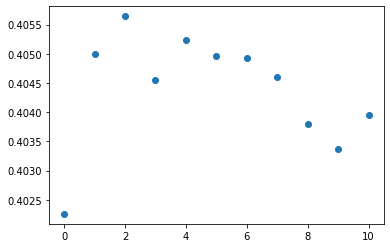

In [77]:
from scipy.special import logit, expit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

names = pd.Index(['gene' + str(i) for i in range(1, 5001)]) & psix_5.index

pos = []
neg = []
order = []
y = []
for i in range(5000):
    if ('gene'+str(i+1)) in psix_5.index:

        if (platonic_psi.loc['gene'+str(i+1)].max() - platonic_psi.loc['gene'+str(i+1)].min()) >= 0.2:
            y.append(1)
            pos.append('gene'+str(i+1))
            order.append('gene'+str(i+1))
        else:
#         elif ds[i] == 0:
            neg.append('gene'+str(i+1))
            y.append(0)
            order.append('gene'+str(i+1))
    
    
recall_list = []
for x in [psix_5, psix_10, psix_20, psix_30, psix_50, psix_100, psix_150, psix_200, psix_300, psix_400, psix_500]:
    pre, rec, thres = precision_recall_curve(y, x.loc[order].psix_score)
    
    recall_list.append(auc(rec, pre))

# recall_list = [f1_score(y, x.loc[order].qvals <= 0.05) for x in [psix_5, psix_10, psix_20, psix_30, psix_50, psix_100, 
#                                                                 psix_150, psix_200, psix_300, psix_400, psix_500]]
plt.scatter(range(len(recall_list)), recall_list)

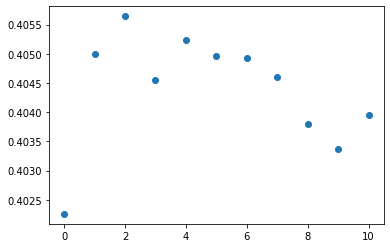

In [83]:
pos = []
neg = []
for i in range(5000):
    if ('gene'+str(i+1)) in psix_5.index:

        if (platonic_psi.loc['gene'+str(i+1)].max() - platonic_psi.loc['gene'+str(i+1)].min()) >= 0.2:
            pos.append('gene'+str(i+1))
        else:
        #elif ds[i] == 0:
            neg.append('gene'+str(i+1))

    
labels = [1]*len(pos) + [0]*len(neg)
order = list(pos) + list(neg)

    
y_ = list(((platonic_psi.max(axis=1) - platonic_psi.min(axis=1)) >= 0.2).astype(int).loc[order])

recall_list = []
for x in [psix_5, psix_10, psix_20, psix_30, psix_50, psix_100, psix_150, psix_200, psix_300, psix_400, psix_500]:
    pre, rec, thres = precision_recall_curve(y_, x.loc[order].psix_score)
    
    recall_list.append(auc(rec, pre))

plt.scatter(range(len(recall_list)), recall_list)

In [75]:
psix_500

,psix_score,pvals,qvals
gene3744,1.164688,0.000500,0.001568
gene3635,1.154263,0.000500,0.001568
gene2931,1.050141,0.000500,0.001568
gene1325,1.007806,0.000500,0.001568
gene71,0.987919,0.000500,0.001568
...,...,...,...
gene2840,-0.063577,1.000000,1.000000
gene4999,-0.076339,1.000000,1.000000
gene730,-0.078039,0.997501,1.000000
gene10,-0.084819,1.000000,1.000000
